In [2]:
import csv
import time
from pylsl import StreamInlet, resolve_byprop
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import math
import sys

# マーカー付きデータをｃｓｖ保存
def save_data_to_csv(start_time, timestamp, sample, filename):
    # 開始と終了の3つの要素を削除し、タイムスタンプを0から始まるように修正
    sample = sample[3:-2]
    timestamp -= start_time
    
    # DataFrameを作成し、データを追記していく
    # sampleはリスト形式でデータが渡される
    # マーカーもこのDataFrameに格納
    # タイムスタンプを先頭に追加
    df = pd.DataFrame([[timestamp] + sample])  

    with open(filename, 'a') as f:
        df.to_csv(f, header=f.tell() == 0, index=False, lineterminator='\n')  # headerはファイルの先頭だけに出力


#CSVファイルからデータを読み込む関数
def load_data_from_csv(filename):
    data = []
    with open(filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            data.append(row)

    return data

# データをプロットする関数
def plot_data(data, channels):
    timestamps = [float(row['Timestamp']) for row in data]

    plt.figure(figsize=(15, 8))

    for channel in channels:
        values = [float(row[channel]) for row in data]
        plt.plot(timestamps, values, label=channel)

    plt.xlabel('Timestamp (s)')
    plt.ylabel('Sensor Value')
    plt.title('Brainwave Data')
    plt.legend()
    plt.show()
    
    
def lsl_to_local_datetime(lsl_timestamp):
    return datetime.fromtimestamp(lsl_timestamp)


# 256Hzで収集（デフォルト）
def collect_EEG(filename, duration):
    # EPOCXのストリームを探す
    streams = resolve_byprop('type', 'EEG', timeout=5)

    if not streams:
        raise RuntimeError("No EEG stream found. Make sure the EmotivPro LSL Connector is running.")

    # ストリームを開く
    inlet = StreamInlet(streams[0])

    print("Connected to Emotiv EPOC FLEX stream.")

    # ファイルを上書きモードで開く
    with open(filename, 'w') as f:
        # チャンネル名のラベルを設定
        header = ['Timestamp'] + ['Cz', 'Fz', 'Fp1', 'F3', 'C1', 'C3', 'T7', 'C5', 'CP5', 'CP3', 
                                  'CP1', 'P1', 'P3', 'O1', 'CPz', 'Pz', 'Oz', 'O2', 'P4', 'P2',
                                  'CP2', 'CP4', 'CP6', 'C6', 'T8', 'C4', 'C2', 'F4', "Fp2"]
        f.write(','.join(header) + '\n')

    # データを取得し、CSVファイルに記録する
    start_time = None
    while True:
        sample, timestamp = inlet.pull_sample()
        if start_time is None:
            start_time = timestamp
        elapsed_time = timestamp - start_time
            
        save_data_to_csv(start_time, timestamp, sample, filename)
            
        if elapsed_time >= duration:
            break
    return

In [22]:
# CSVファイル名を指定
filename = 'PilotResearch_LF3_H.csv'
#収集するデータの期間（秒）
duration = 5 
#EEGを収集し、csvファイルに保存
collect_EEG(filename, duration)

Connected to Emotiv EPOC FLEX stream.


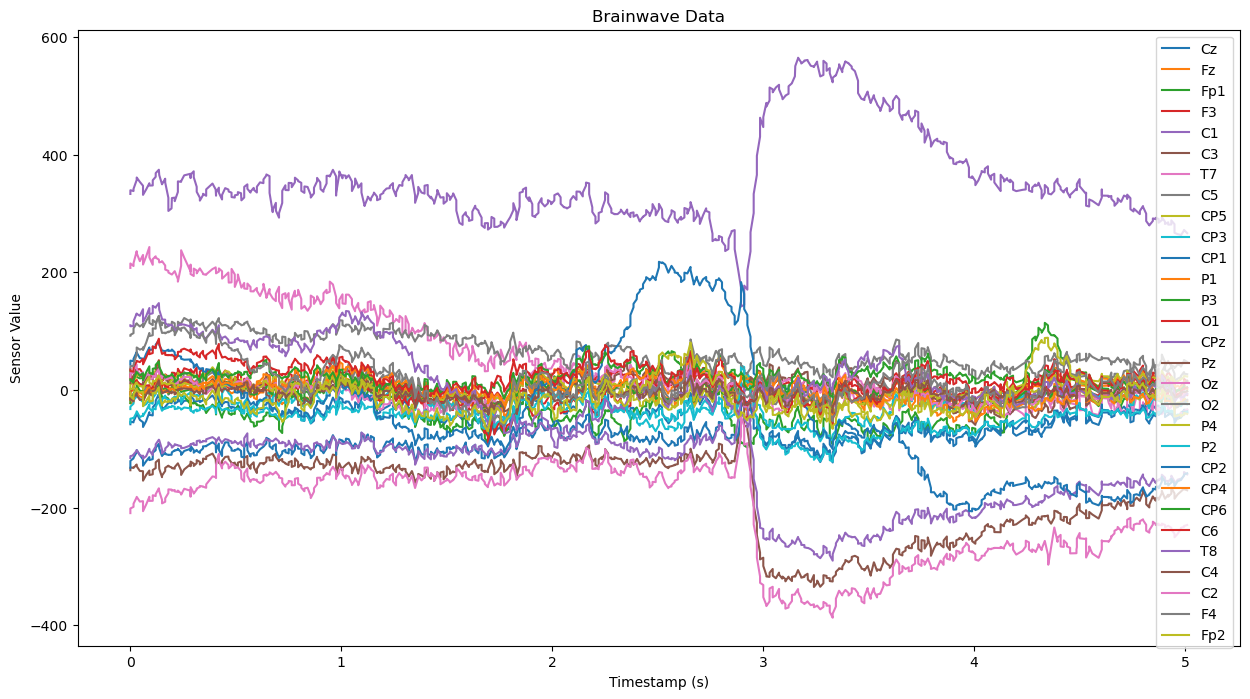

In [25]:
filename = 'PilotResearch_U2_H.csv'

# 選択したチャンネル名
channels = ['Cz', 'Fz', 'Fp1', 'F3', 'C1', 'C3', 'T7', 'C5', 'CP5', 'CP3',
            'CP1', 'P1', 'P3', 'O1', 'CPz', 'Pz', 'Oz', 'O2', 'P4', 'P2',
            'CP2', 'CP4', 'CP6', 'C6', 'T8', 'C4', 'C2', 'F4', "Fp2"]
data = load_data_from_csv(filename)
plot_data(data, channels)